<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>Applied Data Analysis </h1>
<h1>ATM/MPO 624, spring 2020</h1>
<h2>Modeling the meaning of our data</h2>


## Subdividing time into different timescales

Sisam has radiation datasets at surface and top of atmosphere, longwave and shortwave, upwelling and downwelling. Sums and differences are radiative budgets for the surface, atmosphere, or whole column. She has these for all-sky and clear-sky conditions, so clever differences can isolate the cloud effect C (sometimes called CRE, cloud radiative impacts). From upwelling longwave at the ocean surface, one could compute SST by inverting $LWUP_{sfc} = 0.98 \sigma (SST)^4$ since 0.98 is the emissivity of sea water. 

Let's rewrite C's shape as a function of longitude, latitude, and time  

$C(\lambda,\phi, t)$

in a clever way, subdividing time into year (yyyy), day-of year (doy), and hour of day (hod) in an astronomical form:

$C(\lambda,\phi, yyyy, doy, hod)$

or in a  calendar-clock form as:

$C(\lambda,\phi, yyyy, mm, dd, hh)$


### Problems for all

1. Show that the area-average over the Earth's surface requires a cosine-weighting of latitude:  

$\int_{0}^{360} \int_{-90}^{90} C(\lambda, \phi, t) cos(\phi) d\phi d\lambda$


= $\int_{0}^{360} \int_{-1}^{1} C(\lambda, \phi, t) d(sin(\phi)) d\lambda$

Let's make a notation with a dash for averaged values. For instance, the global mean climatological seasonal cycle of CRE is $C(-,-,-,doy,-)$ in astronomical form. The equatorial time-longitude section of December means is $C(\lambda,0,yyyy,12,-,-)$ in calendar-clock form.  
1. Write the form for the climatological annual cycle of zonal mean C. 


$C(-,\phi,-,mm,-)$ in calendar-clock form

2. Sketch a contour graph of TOA incoming radiation $I(\lambda,-,-,-,hod)$ in astronomical form. 


3. Sketch a line graph of TOA incoming radiation I(-,0,-,doy,-), and a line graph of TOA incoming radiation I(-,90,-,doy,-).

4. How would you write in this notation the multi-year equatorial time-longitude plot of C with its seasonal cycle subtracted, like the SST and u and OLR views of ENSO which we have been studying in the example notebooks? 

$C(\lambda,0,yyyy,-,-)$ in calendar-clock form

5. How could you express in this notation the hypothesis or posulate that the *slope of the scatter plot of C vs. T over the mean annual cycle is the same as the slope of the scatter plot of C vs. T over interannual variability* at some point in the subtropical southeast Pacific? 

Sisam, would you care to build the clever-differnecing and averaging tools to make these kinds of C and SST arrays, and perhaps use them to test such a hypothesis? 

**(This is just my crude recall of what is in Sisam's earlier work, in her [fork](https://github.com/sisams/MPO624-2020)), and seems related to Haozhe's work too [fork](https://github.com/Realmadridhz/MPO624-2020). Sisam, Haozhe, feel free to take over & make it make better sense!**

In [108]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from datetime import datetime

In [3]:
pip install dill

Note: you may need to restart the kernel to use updated packages.


In [1]:
import dill
dill.dump_session('notebook_env.db')


In [5]:
#import data for SFC fluxes
dataset = xr.open_dataset('/bsoden/CERES/CERES_SFC_CMIP.nc')

#import data for TOA fluxes (this has 1 year extra:2017)
dataset2 = xr.open_dataset('/bsoden/CERES/CERES_TOA_CMIP.nc')

#data = dataset.sel (lat=0, method ='nearest')

#slice the dataset to remove the awkward starting in 2006
dataset=dataset.sel(time=slice(datetime(2001,1,16),datetime(2017,12,16)))
dataset2=dataset2.sel(time=slice(datetime(2001,1,16),datetime(2017,1,1)))

lat = dataset2['lat'].values
NH = lat[lat>0]
SH = lat[lat<0]

lon = dataset2['lon'].values
EH = lon[lon<180.5]
WH = lon[lon>180]


# Cloud Radiative Effect at TOA #

$C = SW_{UP,clear} - SW_{UP,total} + LW_{UP,clear} - LW_{UP,total}$

In [6]:
#calculate SW CRE at TOA
sutc = dataset2.rsutcs -dataset2.rsut


#claculate LW CRE at TOA
lutc = dataset2.rlutcs - dataset2.rlut



In [37]:
#calculte TOA Cloud Radiative Effect

c = sutc + lutc
cNH = c.sel(lat=slice(0,90))        #Northern hemisphere
cSH = c.sel(lat=slice(-90,0))       #Southern hemisphere
cEH = c.sel(lon=EH)                 #Eastern hemisphere
cWH = c.sel(lon=WH)                 #Western hemisphere


#I had to make new arrays for reshaping calculations later on
C = np.copy(c)
CNH =np.copy(cNH)
CSH = np.copy(cSH)
CEH = np.copy(cEH)
CWH = np.copy(cWH)


Text(0.5, 1.0, 'Cosine weights of latitude')

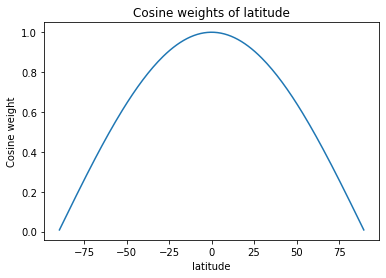

In [8]:
#weights for longitiude/latitude averaging
weight = np.cos(lat*np.pi/180.0)        #global
weightN = np.cos(NH*np.pi/180.0)        #NH
weightS = np.cos(SH*np.pi/180.0)        #SH

#plot cosine weighting
plt.plot(lat, weight)
plt.ylabel('Cosine weight')
plt.xlabel('latitude')
plt.title('Cosine weights of latitude')

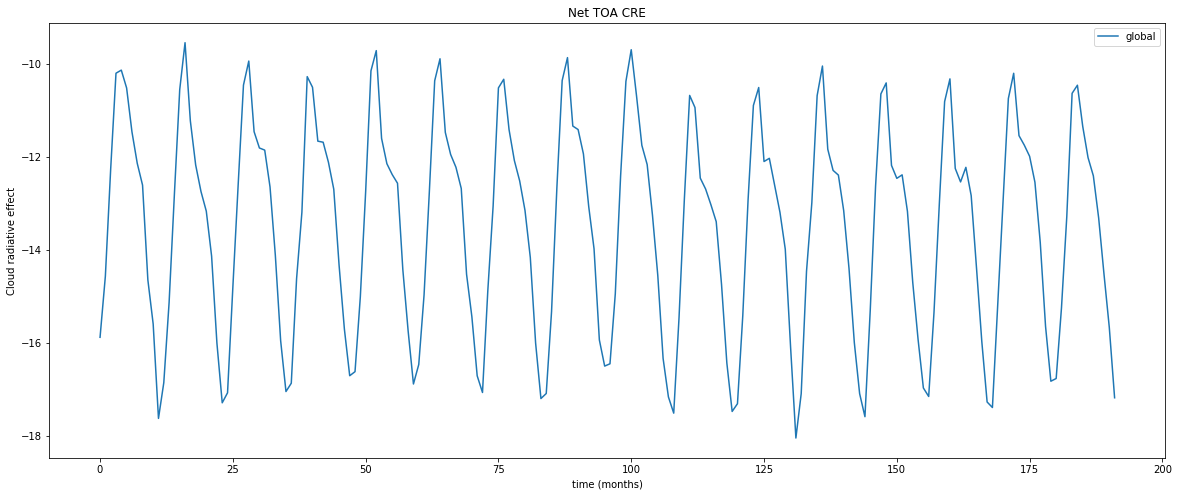

In [9]:
#global mean cloud radiative effect at TOA
C_glbmean = np.mean(np.mean(C,axis=2)*weight,axis=1)


fig, ax = plt.subplots(figsize=(20,8))
ax.plot(C_glbmean, label ='global')
ax.set(xlabel='time (months)', ylabel='Cloud radiative effect', title ='Net TOA CRE')
ax.legend()

## We can clearly see annual cycles for the 16 years. However, there seems to be a presence of a slight interannual cycle ##

Text(0.5, 1.0, 'real part: the mean, then a symmetric repeat of the spectrum')

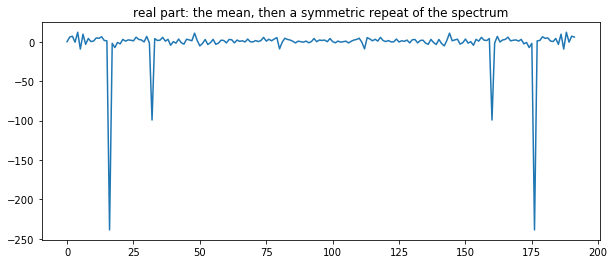

In [10]:
#power pecturm attempt 

T = C_glbmean; NT = len(T)
Tp = T - T.mean()
Tspec = np.fft.fft( Tp )

fig,ax = plt.subplots(1,1,figsize=(10,4)); 
ax.plot(Tspec.real)
plt.title('real part: the mean, then a symmetric repeat of the spectrum')


In [11]:
# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)

freqs = np.array(range(NT))   # This gets the left end correct
reversed_freqs = freqs[::-1]  # Reverse the array 
reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
freqs = reversed_freqs[::-1]  # reverse it back


/home/sshrestha/anaconda3/envs/unidata/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


Text(0.5, 1.0, 'Discrete spectrum')

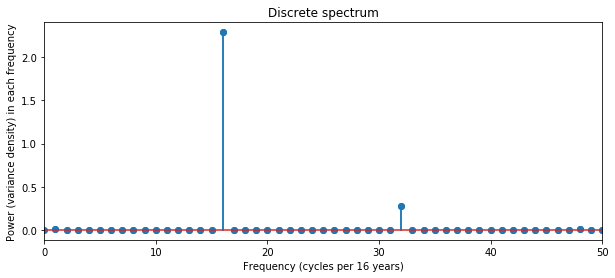

In [12]:
Power = (Tspec.conjugate()*Tspec).real
Power = Power*(np.var(Tp) / Power.sum())       # Enforce Parseval's theorem for variance 
fig,ax = plt.subplots(1,1,figsize=(10,4)); 

ax.stem(freqs, Power)
ax.set_xlim([0,50])
ax.set_xlabel('Frequency (cycles per 16 years)')
ax.set_ylabel('Power (variance density) in each frequency')
plt.title('Discrete spectrum')


Text(0.5, 1.0, 'P(f) as a line graph')

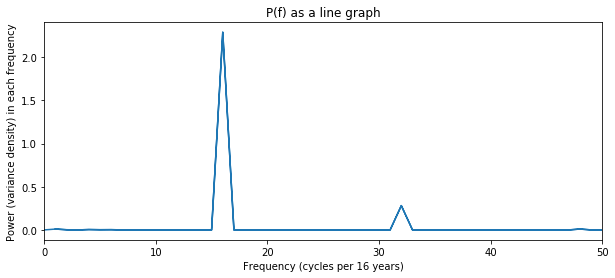

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10,4)); 

ax.plot(freqs, Power)
ax.set_xlim([0,50])
ax.set_xlabel('Frequency (cycles per 16 years)')
ax.set_ylabel('Power (variance density) in each frequency')
plt.title('P(f) as a line graph')


Text(0.5, 1.0, 'TOA CRE')

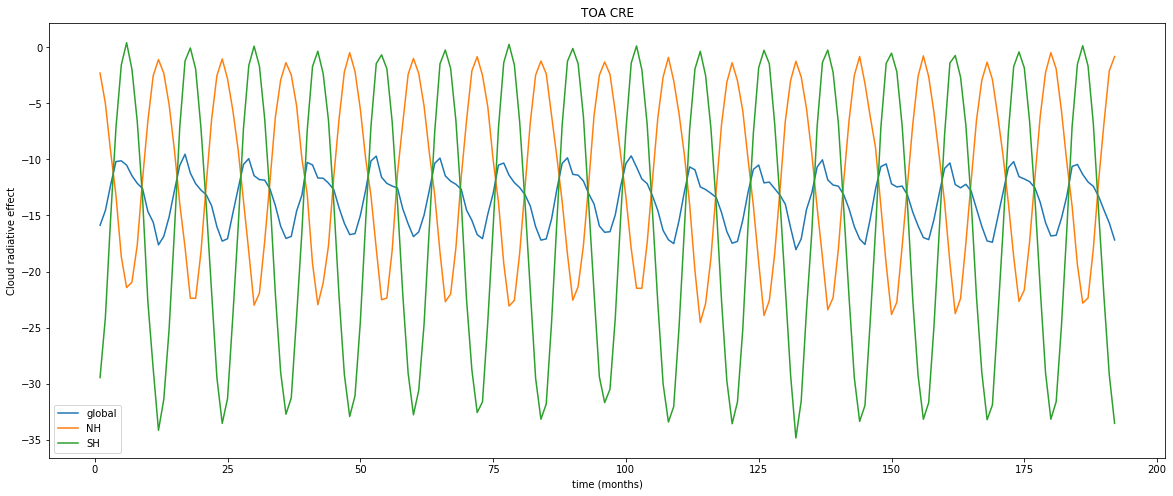

In [14]:
#check hemisphere effect SH/NH

NH_mean = np.mean(np.mean(CNH,axis=2)*weightN,axis=1)
SH_mean = np.mean(np.mean(CSH,axis=2)*weightS,axis=1)

time = np.arange(1, C.shape[0]+1)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(time, C_glbmean, label ='global')
ax.plot(time,NH_mean, label='NH')
ax.plot(time,SH_mean, label='SH')
ax.legend()
ax.set(xlabel='time (months)', ylabel='Cloud radiative effect')
plt.title('TOA CRE')

Text(0.5, 1.0, 'TOA CRE')

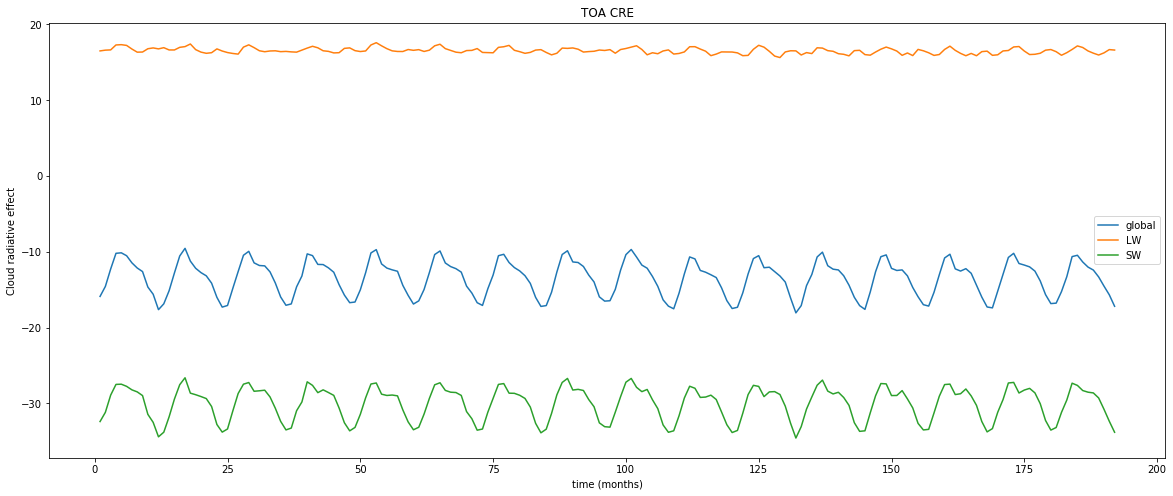

In [15]:
#check lw vs short wave CRE
LW_gmean = np.mean(np.mean(lutc,axis=2)*weight,axis=1)
SW_gmean = np.mean(np.mean(sutc,axis=2)*weight,axis=1)

time = np.arange(1, C.shape[0]+1)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(time, C_glbmean, label ='global')
ax.plot(time,LW_gmean, label='LW')
ax.plot(time,SW_gmean, label='SW')
ax.legend()
ax.set(xlabel='time (months)', ylabel='Cloud radiative effect')
plt.title('TOA CRE')

Text(0.5, 1.0, 'TOA CRE')

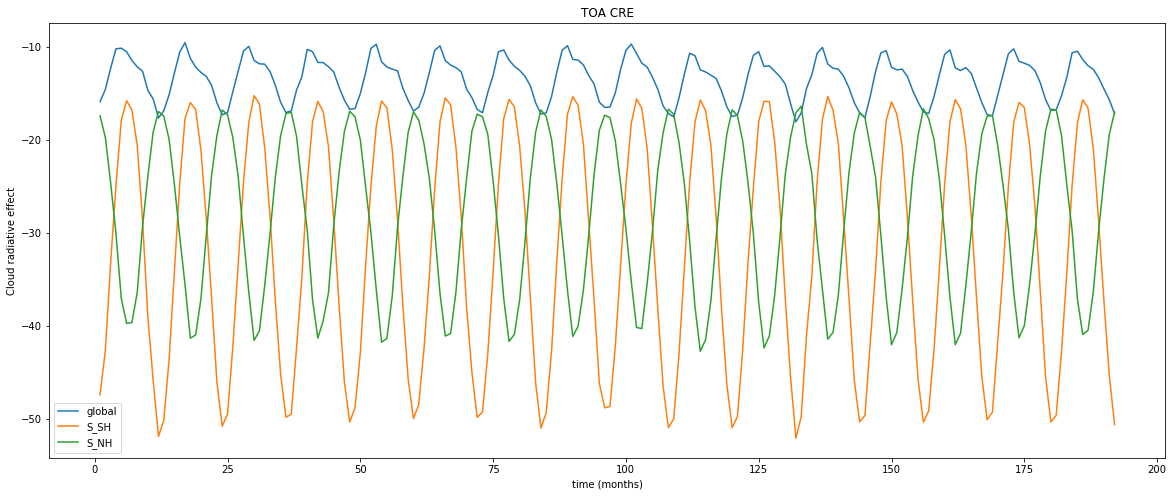

In [16]:
#check if it's the SH/NH SW CRE
SW_SH = sutc.sel(lat=slice(-90,0))
SW_NH = sutc.sel(lat=slice(0,90))


SW_SHm = np.mean(np.mean(SW_SH,axis=2)*weightS,axis=1)
SW_NHm = np.mean(np.mean(SW_NH,axis=2)*weightN,axis=1)


time = np.arange(1, C.shape[0]+1)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(time, C_glbmean, label ='global')
ax.plot(time,SW_SHm, label='S_SH')
ax.plot(time,SW_NHm, label ='S_NH')
ax.legend()
ax.set(xlabel='time (months)', ylabel='Cloud radiative effect')
plt.title('TOA CRE')

Text(0.5, 1.0, 'TOA CRE')

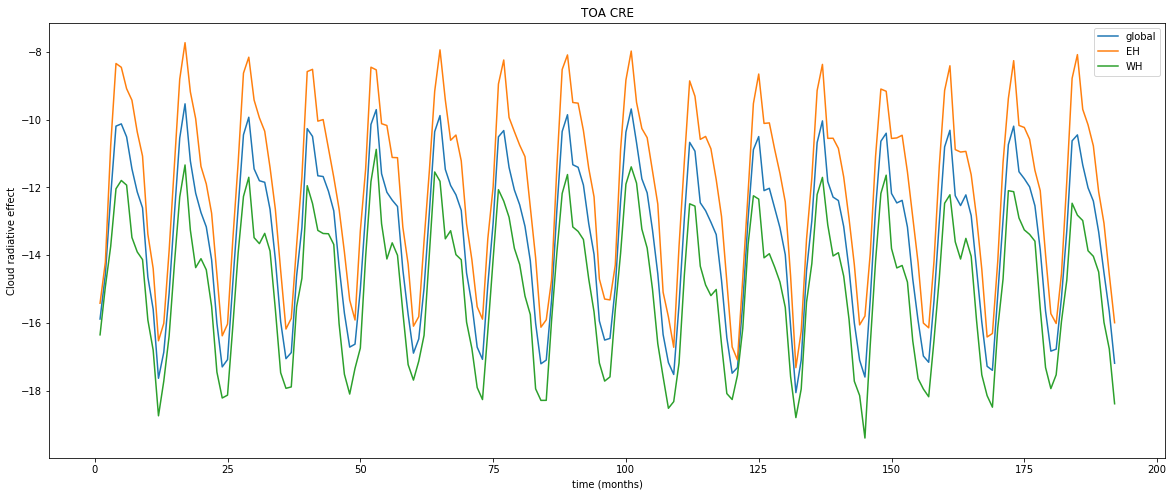

In [17]:
#check eastern/western hemisphere
EH_mean = np.mean(np.mean(CEH,axis=2)*weight,axis=1)
WH_mean = np.mean(np.mean(CWH,axis=2)*weight,axis=1)

time = np.arange(1, C.shape[0]+1)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(time, C_glbmean, label ='global')
ax.plot(time,EH_mean, label='EH')
ax.plot(time,WH_mean, label='WH')
ax.legend()
ax.set(xlabel='time (months)', ylabel='Cloud radiative effect')
plt.title('TOA CRE')

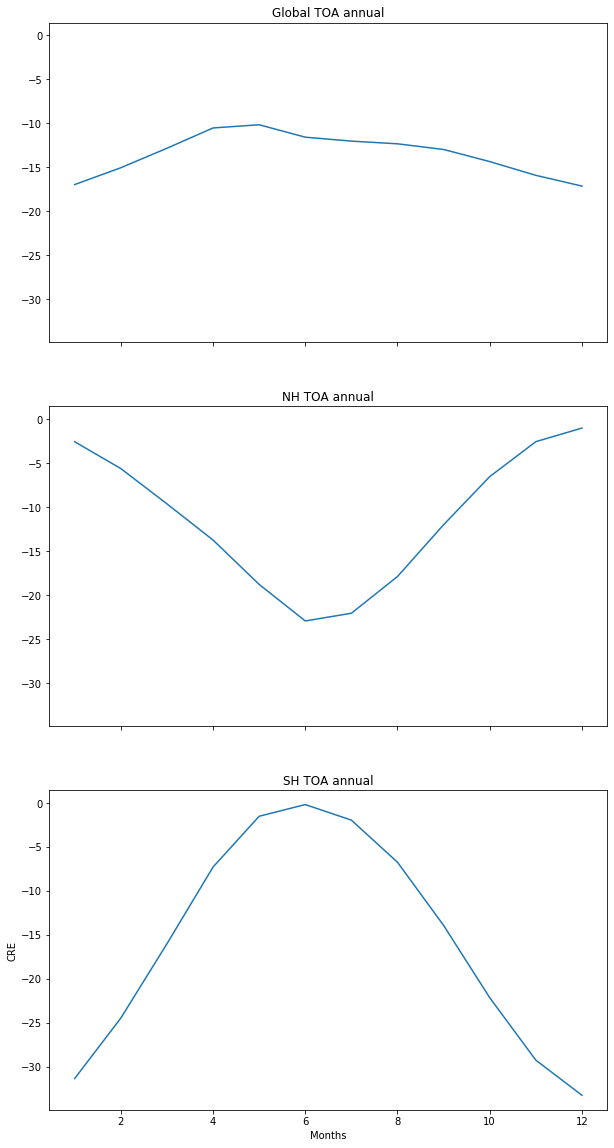

In [18]:
#reshaped the TOA CRE to get 16 years/12 months
C_rshp = C.reshape(16,12,180,360)
C_acycle = np.mean(np.mean(np.mean(C_rshp,axis=3)*weight,axis=2),axis=0)

#reshaping for NH
CNH_rshp = CNH.reshape(16,12,90,360)
CNH_acycle = np.mean(np.mean(np.mean(CNH_rshp,axis=3)*weightN,axis=2),axis=0)

#reshaping for NH
CSH_rshp = CSH.reshape(16,12,90,360)
CSH_acycle = np.mean(np.mean(np.mean(CSH_rshp,axis=3)*weightS,axis=2),axis=0)

time = np.arange(1, len(C_acycle)+1)


fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10,20))
ax[0].plot(time,C_acycle, label ='TOA annual cycle')
ax[1].plot(time,CNH_acycle, label ='TOA annual cycle')
ax[2].plot(time,CSH_acycle, label ='TOA annual cycle')

ax[0].title.set_text('Global TOA annual')
ax[1].title.set_text('NH TOA annual')
ax[2].title.set_text('SH TOA annual')


plt.xlabel('Months')
plt.ylabel('CRE')
plt.show()


In [19]:
#sine of latitude
slat = np.sin(np.deg2rad(lat))

#zonally averaged CRE. Here, C is the net TOA CRE (time,lat,lon) that I've already calculated. I have 16 years of monthly data
z_CRE = np.mean(C,axis=2)

#flip axes to plot against time
a=z_CRE.transpose()

a.shape

(180, 192)

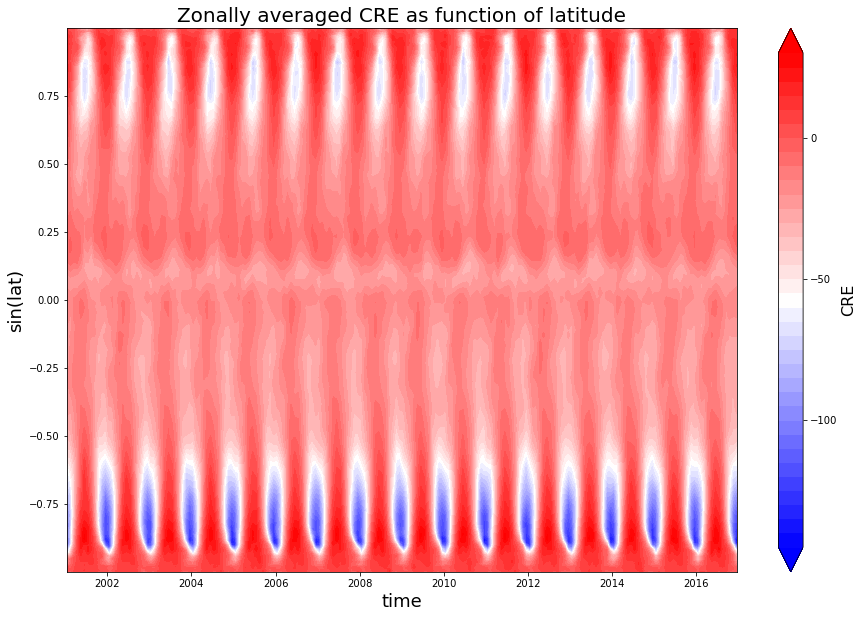

In [20]:
#plot the contour
# plot timeseries of SST 
fig=plt.figure(figsize=[15,10])
ax=fig.add_subplot(111)
cs = ax.contourf(dataset.time,slat,a,40,cmap='bwr',extend='both')
cb = plt.colorbar(cs,ticks=np.arange(-150,150,50))
cb.set_label('CRE',fontsize=16)
ax.set_title('Zonally averaged CRE as function of latitude',fontsize=20)
ax.set_ylabel('sin(lat)',fontsize=18)
ax.set_xlabel('time',fontsize=18)
plt.show()

<hr style="height:2px;">


# Cloud Radiative Effect at the Surface #

$C = SW_{DOWN,total} - SW_{DOWN,clear} + SW_{UP,clear} - SW_{UP,total} + LW_{DOWN,total} - LW_{DOWN,clear}$

In [76]:
#calculate SW CRE at surface

ss = dataset.rsds - dataset.rsdscs + dataset.rsuscs - dataset.rsus

#calculate LW CRE at surface
ls = dataset.rlds - dataset.rldscs

#caculate CRE at surface
CS = ss + ls
CSNH = CS.sel(lat=slice(0,90))        #Northern hemisphere
CSSH = CS.sel(lat=slice(-90,0))       #Southern hemisphere
CSEH = CS.sel(lon=EH)                 #Eastern hemisphere
CSWH = CS.sel(lon=WH)                 #Western hemisphere

cS = np.copy(CS)
cSNH = np.copy(CSNH)
cSSH = np.copy(CSSH)

Text(0.5, 1.0, 'Surface CRE')

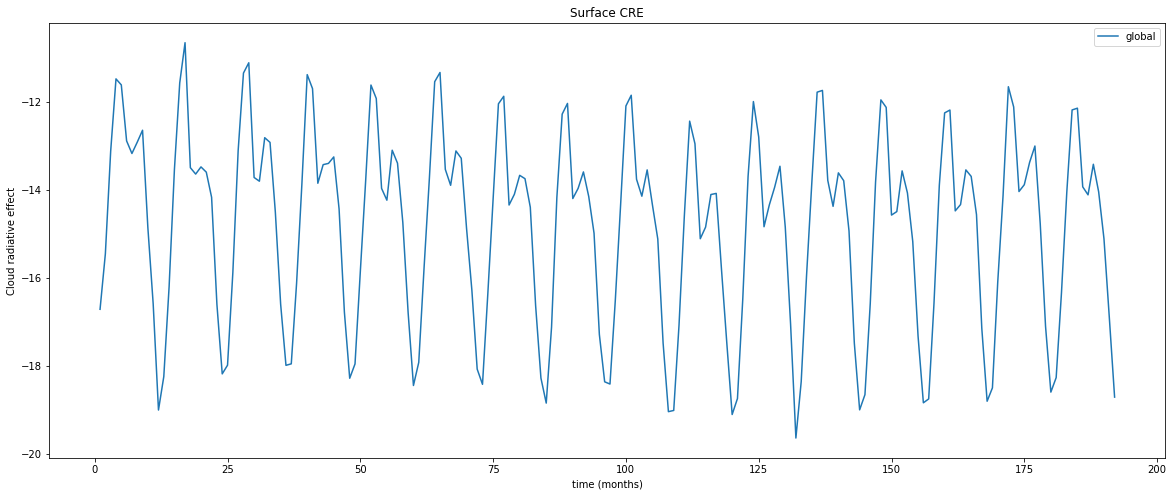

In [77]:
CS_glbmean = np.nanmean(np.nanmean(CS,axis=2)*weight,axis=1)
time = np.arange(1, CS.shape[0]+1)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(time, CS_glbmean, label ='global')
ax.legend()

ax.set(xlabel='time (months)', ylabel='Cloud radiative effect')

plt.title('Surface CRE')

Text(0.5, 1.0, 'real part: the mean, then a symmetric repeat of the spectrum')

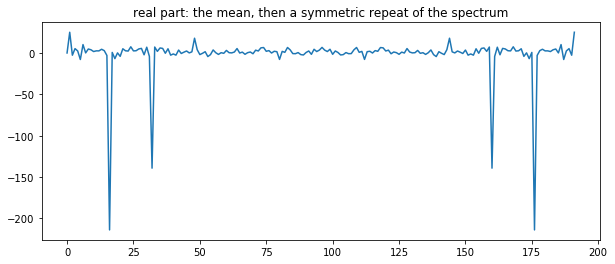

In [78]:
#power pecturm attempt 

S = CS_glbmean
NS = len(S)
Sp = S - S.mean()
Sspec = np.fft.fft( Sp )

fig,ax = plt.subplots(1,1,figsize=(10,4)); 
ax.plot(Sspec.real)
plt.title('real part: the mean, then a symmetric repeat of the spectrum')
#ax.plot(Vspec.imag)


In [79]:
# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)

freqsS = np.array(range(NS))   # This gets the left end correct
reversed_freqsS = freqsS[::-1]  # Reverse the array 
reversed_freqsS[0:int(NS/2)] = freqsS[1:int(NS/2)+1] # Fix the low end of the reversed array
freqsS = reversed_freqsS[::-1]  # reverse it back

/home/sshrestha/anaconda3/envs/unidata/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


Text(0.5, 1.0, 'Discrete spectrum')

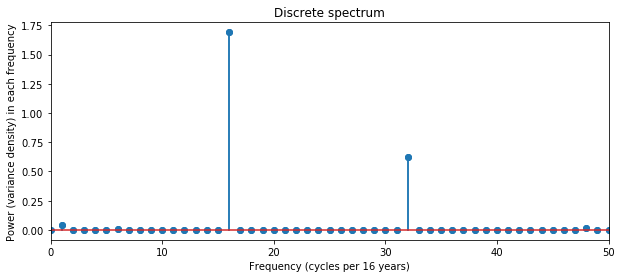

In [80]:
PowerS = (Sspec.conjugate()*Sspec).real
PowerS *= np.var(Sp) / PowerS.sum()       # Enforce Parseval's theorem for variance 
fig,ax = plt.subplots(1,1,figsize=(10,4)); 

ax.stem(freqsS, PowerS)
ax.set_xlim([0,50])
ax.set_xlabel('Frequency (cycles per 16 years)')
ax.set_ylabel('Power (variance density) in each frequency')
plt.title('Discrete spectrum')

#print('V0ariance is', Vp.var(), '(m/s)^2: matches', sum(Power))


Text(0.5, 1.0, 'P(f) as a line graph')

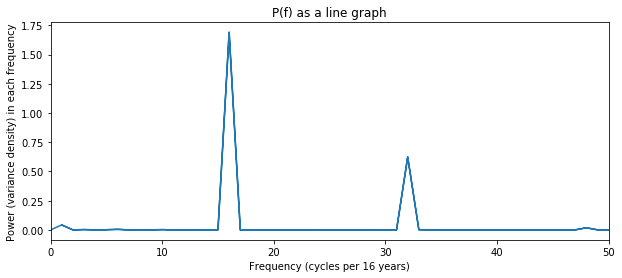

In [81]:
fig,ax = plt.subplots(1,1,figsize=(10,4)); 

ax.plot(freqsS, PowerS)
ax.set_xlim([0,50])
ax.set_xlabel('Frequency (cycles per 16 years)')
ax.set_ylabel('Power (variance density) in each frequency')
plt.title('P(f) as a line graph')


Text(0.5, 1.0, 'Surface CRE')

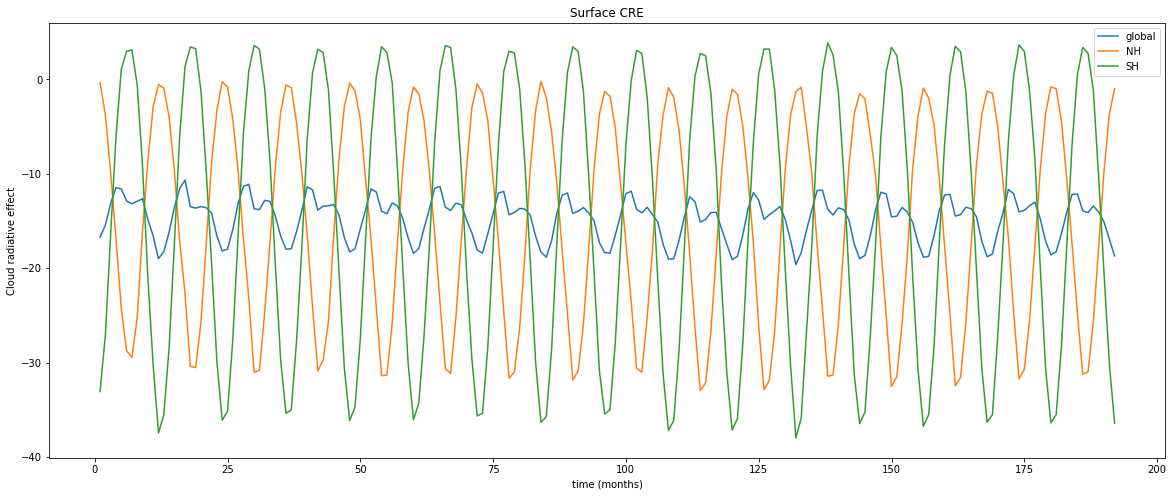

In [82]:
#check the hemispheric effect for SH/NH
CSNH_mean = np.mean(np.mean(CSNH,axis=2)*weightN,axis=1)
CSSH_mean = np.mean(np.mean(CSSH,axis=2)*weightS,axis=1)


time = np.arange(1, CS.shape[0]+1)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(time, CS_glbmean, label ='global')
ax.plot(time,CSNH_mean, label='NH')
ax.plot(time,CSSH_mean, label='SH')
ax.legend()

ax.set(xlabel='time (months)', ylabel='Cloud radiative effect')
plt.title('Surface CRE')

Text(0.5, 1.0, 'Surface CRE')

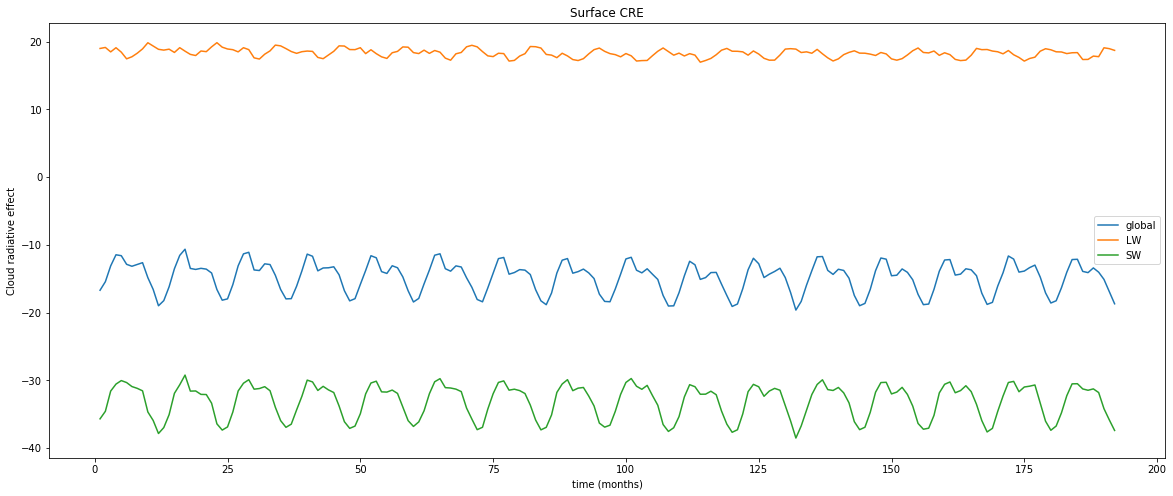

In [83]:
#check SW vs LW effect
LW_s = np.mean(np.mean(ls,axis=2)*weight,axis=1)
SW_s = np.mean(np.mean(ss,axis=2)*weight,axis=1)

time = np.arange(1, CS.shape[0]+1)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(time, CS_glbmean, label ='global')
ax.plot(time,LW_s, label='LW')
ax.plot(time,SW_s, label='SW')
ax.legend()
ax.set(xlabel='time (months)', ylabel='Cloud radiative effect')
plt.title('Surface CRE')

Text(0.5, 1.0, 'Surface CRE')

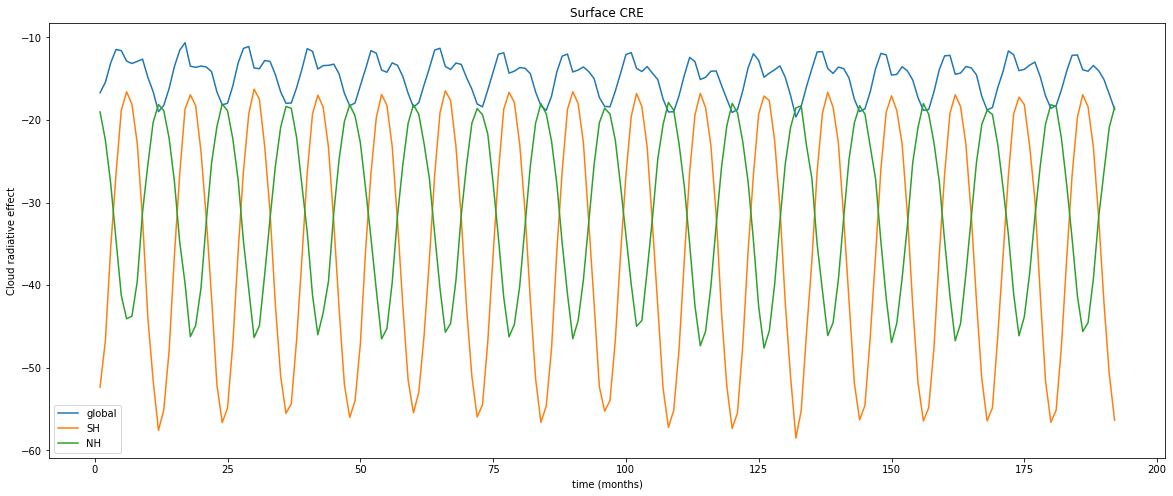

In [84]:
#SW of SH/NH
SW_SHs = ss.sel(lat=slice(-90,0))
SW_NHs = ss.sel(lat=slice(0,90))

SW_SHsm = np.mean(np.mean(SW_SHs,axis=2)*weightS,axis=1)
SW_NHsm = np.mean(np.mean(SW_NHs,axis=2)*weightN,axis=1)

time = np.arange(1, CS.shape[0]+1)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(time, CS_glbmean, label ='global')
ax.plot(time,SW_SHsm, label='SH')
ax.plot(time,SW_NHsm, label='NH')
ax.legend()
ax.set(xlabel='time (months)', ylabel='Cloud radiative effect')
plt.title('Surface CRE')

[Text(0, 0.5, 'Cloud radiative effect'), Text(0.5, 0, 'time (months)')]

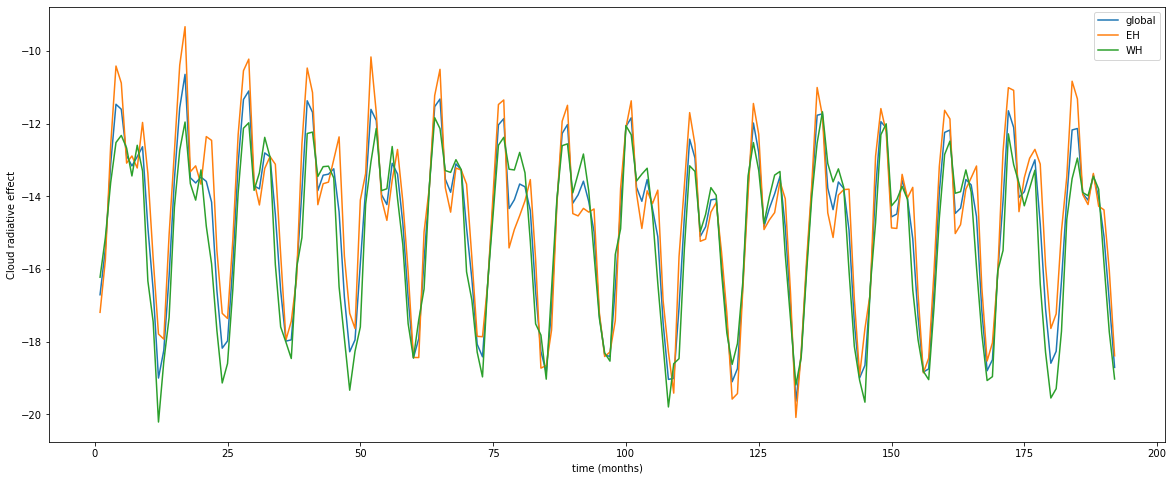

In [85]:
#check eastern/western hemisphere
EHs_mean = np.mean(np.mean(CSEH,axis=2)*weight,axis=1)
WHs_mean = np.mean(np.mean(CSWH,axis=2)*weight,axis=1)

time = np.arange(1, C.shape[0]+1)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(time, CS_glbmean, label ='global')
ax.plot(time,EHs_mean, label='EH')
ax.plot(time,WHs_mean, label='WH')
ax.legend()
ax.set(xlabel='time (months)', ylabel='Cloud radiative effect')

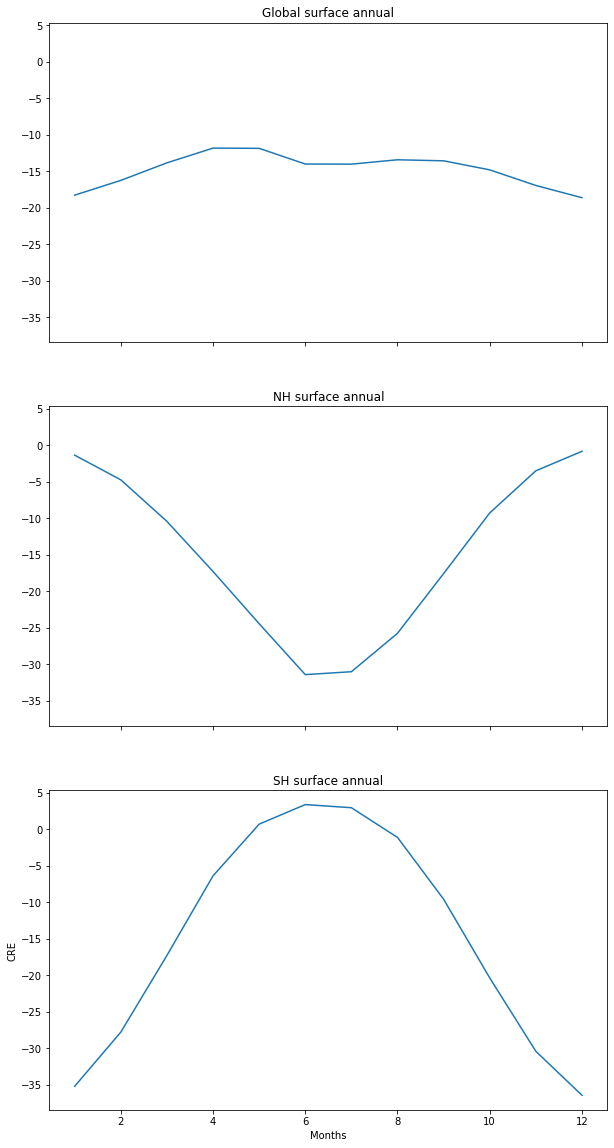

In [86]:
#reshaped the surface CRE to get 16 years/12 months
CS_rshp = cS.reshape(16,12,180,360)
CS_acycle = np.mean(np.mean(np.mean(CS_rshp,axis=3)*weight,axis=2),axis=0)

#reshaping for NH
CSNH_rshp = cSNH.reshape(16,12,90,360)
CSNH_acycle = np.mean(np.mean(np.mean(CSNH_rshp,axis=3)*weightN,axis=2),axis=0)

#reshaping for NH
CSSH_rshp = cSSH.reshape(16,12,90,360)
CSSH_acycle = np.mean(np.mean(np.mean(CSSH_rshp,axis=3)*weightS,axis=2),axis=0)

month = np.arange(1,13)

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10,20))
ax[0].plot(month,CS_acycle)
ax[1].plot(month,CSNH_acycle)
ax[2].plot(month,CSSH_acycle)

ax[0].title.set_text('Global surface annual')
ax[1].title.set_text('NH surface annual')
ax[2].title.set_text('SH surface annual')


plt.xlabel('Months')
plt.ylabel('CRE')
plt.show()

In [31]:
#zonally averaged CRE. 
s_CRE = np.mean(CS,axis=2)

#flip axes to plot against time
b = s_CRE.transpose()


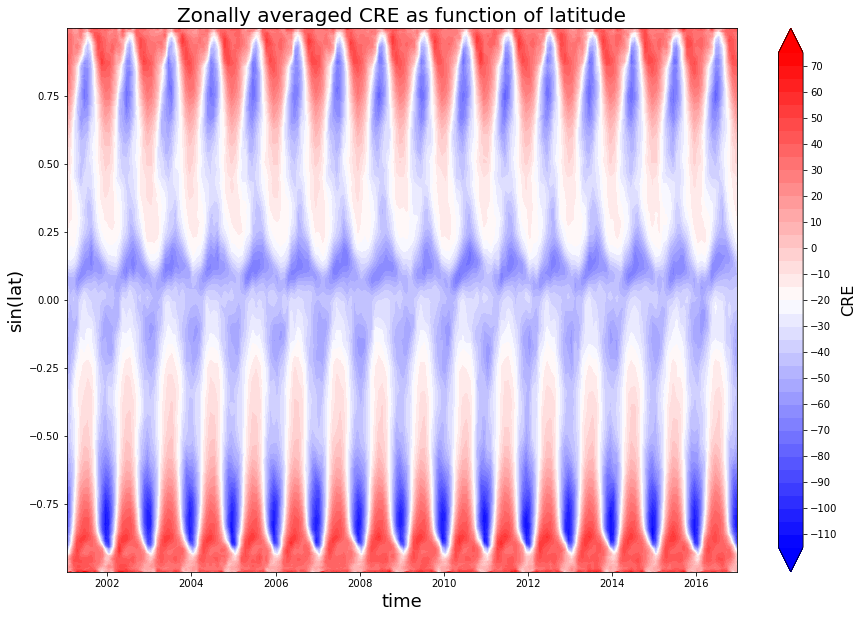

In [32]:
#plot the contour
fig=plt.figure(figsize=[15,10])
ax=fig.add_subplot(111)
cs = ax.contourf(dataset.time,slat,b,40,cmap='bwr',extend='both')
cb = plt.colorbar(cs,ticks=np.arange(-120,100,10))
cb.set_label('CRE',fontsize=16)
ax.set_title('Zonally averaged CRE as function of latitude',fontsize=20)
ax.set_ylabel('sin(lat)',fontsize=18)
ax.set_xlabel('time',fontsize=18)
plt.show()

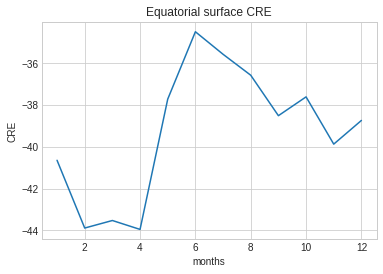

In [109]:
#Surface CRE for equator

eq_s=CS.sel(lat=0.5)
eq_s=np.copy(eq_s)
eq_s_reshaped = eq_s.reshape(16,12,360)
eq_s_annual = np.mean(np.mean(eq_s_reshaped, axis=2),0)
month=np.arange(1, 13)
plt.plot(month,eq_s_annual)
plt.title('Equatorial surface CRE')
plt.xlabel('months')
plt.ylabel('CRE')
plt.show()

## Surface temperature ##

In [99]:
#calculate temperature at SFC
temp = (dataset.rlus/(0.98*5.67e-8))**(1/4)
temp.shape


(192, 180, 360)

In [103]:
#temperature for a point in the southeast Pacific
temp_eq = temp.sel(lat=0.5, lon =270.5)

temp_eq =np.copy(temp_eq)
temp_eq_rshp = temp_eq.reshape(16,12)
temp_eq_annual=np.mean(temp_eq_rshp, axis = 1)    #interannual
temp_eq_szn = np.mean(temp_eq_rshp, axis = 0)     #seasonal

In [104]:
#surface CRE at a point in the southeast pacific
CS_eq = CS.sel(lat=0.5, lon=270.5)
CS_eq = np.copy(CS_eq)
CS_eq_rshp = CS_eq.reshape(16,12)
CS_eq_annual = np.mean(CS_eq_rshp, axis = 1)     #interannaul
CS_eq_szn = np.mean(CS_eq_rshp, axis = 0)        #seasonal


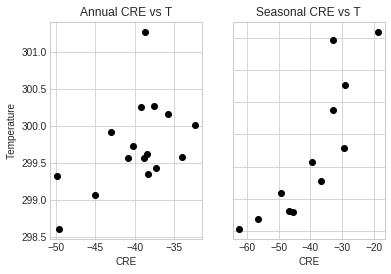

In [112]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(CS_eq_annual,temp_eq_annual, 'o', color='black')
axs[0].set_title('Annual CRE vs T')
axs[1].plot(CS_eq_szn,temp_eq_szn, 'o', color='black')
axs[1].set_title('Seasonal CRE vs T')


for ax in axs.flat:
    ax.set(xlabel='CRE', ylabel='Temperature')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

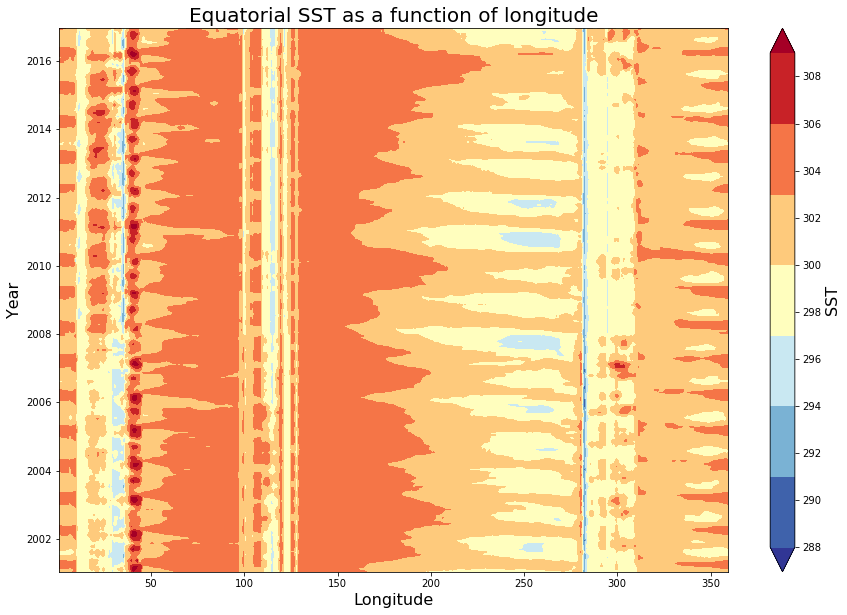

In [62]:
#plot a timeseries of equatorial SST as a function of longitude
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
cs = ax.contourf(datas.lon,datas.time,tempe,cmap='RdYlBu_r',extend='both')
cb = plt.colorbar(cs, ticks=np.arange(280,315+10,2))
cb.set_label('SST',fontsize=16)
ax.set_title('Equatorial SST as a function of longitude',fontsize=20)
ax.set_xlabel('Longitude',fontsize=16)
ax.set_ylabel('Year',fontsize=16)
plt.show()

In [73]:
#calculate zonal mean so that the data only varies temporally and meridionally
temp_anom = tempe - tempe.mean(dim='time')
np.amax(temp_anom)

<xarray.DataArray 'rlus' ()>
array(7.1925354, dtype=float32)
Coordinates:
    lat      float64 0.5

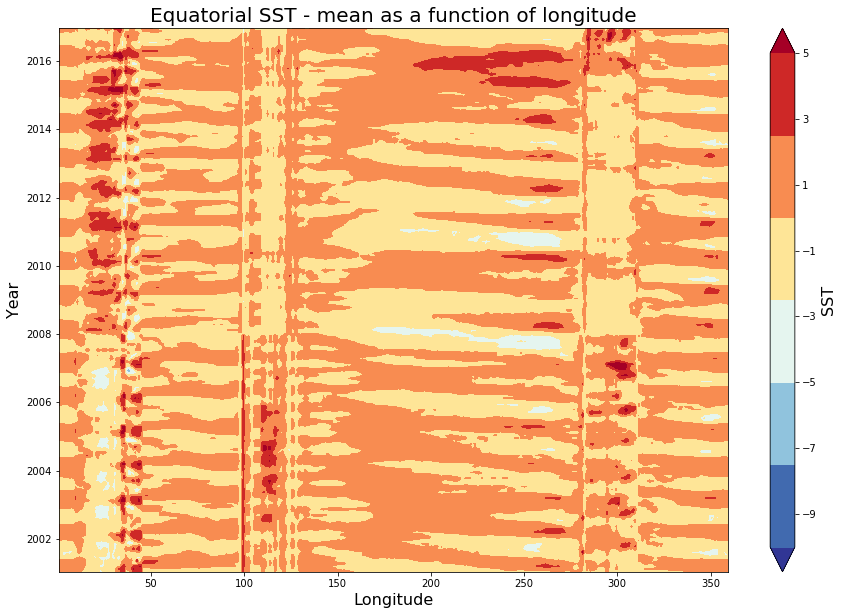

In [74]:
#plot a timeseries of equatorial SST with mean removed as a function of longitude
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
cs = ax.contourf(datas.lon,datas.time,temp_anom,cmap='RdYlBu_r',extend='both')
cb = plt.colorbar(cs, ticks=np.arange(-15,10,2))
cb.set_label('SST',fontsize=16)
ax.set_title('Equatorial SST - mean as a function of longitude',fontsize=20)
ax.set_xlabel('Longitude',fontsize=16)
ax.set_ylabel('Year',fontsize=16)
plt.show()

<a href="#top">Back to top </a>